# Prediction of child's IQ
Julia Krysiak, Sylwia Michalska

## Introduction
In this project we created two different models for predicting child's IQ based on the characteristics of the mother. Despite the controversy surrounding the measurement and significance of IQ, there are practical reasons why predicting IQ can still be useful.

### Controversy around IQ
IQ, or Intelligence Quotient, has long been a subject of debate. Critics argue that IQ tests are culturally biased, do not capture the full spectrum of human intelligence, and may not accurately reflect an individual's cognitive abilities or potential. Research has shown that factors such as socio-economic status, educational opportunities, and even test anxiety can significantly impact IQ scores, calling into question their reliability and validity as a measure of intelligence.

Furthermore, multiple studies suggest that intelligence is multifaceted and cannot be encapsulated by a single numerical score. Howard Gardner's theory of multiple intelligences, for instance, proposes that individuals possess a variety of distinct cognitive abilities, such as linguistic, logical-mathematical, spatial, and interpersonal intelligences, which are not adequately assessed by traditional IQ tests.

### Why prediction of IQ may be useful
While IQ is a controversial measure with significant limitations, its prediction can still offer practical benefits. IQ scores remain widely used in educational and psychological assessments for several practical reasons:
1. Educational Planning: IQ scores can help identify children who may need special educational support. Schools and educators can use this information to tailor educational strategies, design individualized education programs (IEPs), and allocate resources effectively.
2. Parental Guidance: Predicting a child's IQ based on socio-economic and parental factors can provide valuable insights for parents. Understanding how their actions and environment influence their child's cognitive development can help them make informed decisions about education, health, and enrichment activities.
3. Policy Making: Policy makers can use aggregated IQ data to inform decisions on early childhood education programs, social welfare initiatives, and resource allocation. For instance, identifying regions with lower average IQ scores may prompt interventions to improve educational and socio-economic conditions.
4. Research: IQ data, despite its limitations, provides a useful benchmark for psychological and educational research. It can help researchers study the impact of various factors on cognitive development and evaluate the effectiveness of interventions aimed at improving educational outcomes.

## Directed Acyclic Graph


<img title="a title" src="/children’s IQ.png">

## Data Source and Contents
We used 'kidiq' dataset which is available in the 'statsmodels' library. Data includes information on children;s IQ scores and various socio-economic and parental factors. It contains following variables:
```
kid_score: Child's IQ score
mom_hs: Indicator for whether the mother has a high school degree
mom_iq: Mother's IQ score
mom_work:   1 = did not work in first three years of child's life
            2 = worked in 2nd or 3rd year of child's life
            3 = worked part-time in first year of child's life
            4 = worked full-time in first year of child's life
mom_age: Mother's age

```

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from cmdstanpy import CmdStanModel
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("kidiq.csv", sep=";")

In [3]:
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


### Correlation Analysis
This step involves calculating the correlation coefficients between different variables in the dataset to understand the relationships between them. What we found is that there is moderate positive $kid.score$ - $mom.iq$ and $kid.score$ - $mom.hs$ correlation. This indicates that those could be good predictiors for our models.

In [4]:
df.corr()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
kid_score,1.000000,0.035672,0.301510,-0.024535,0.095566
mom_hs,0.035672,1.000000,0.206142,0.045817,0.244039
mom_iq,0.301510,0.206142,1.000000,0.010575,-0.012764
mom_work,-0.024535,0.045817,0.010575,1.000000,0.152207
mom_age,0.095566,0.244039,-0.012764,0.152207,1.000000


### Plotting data

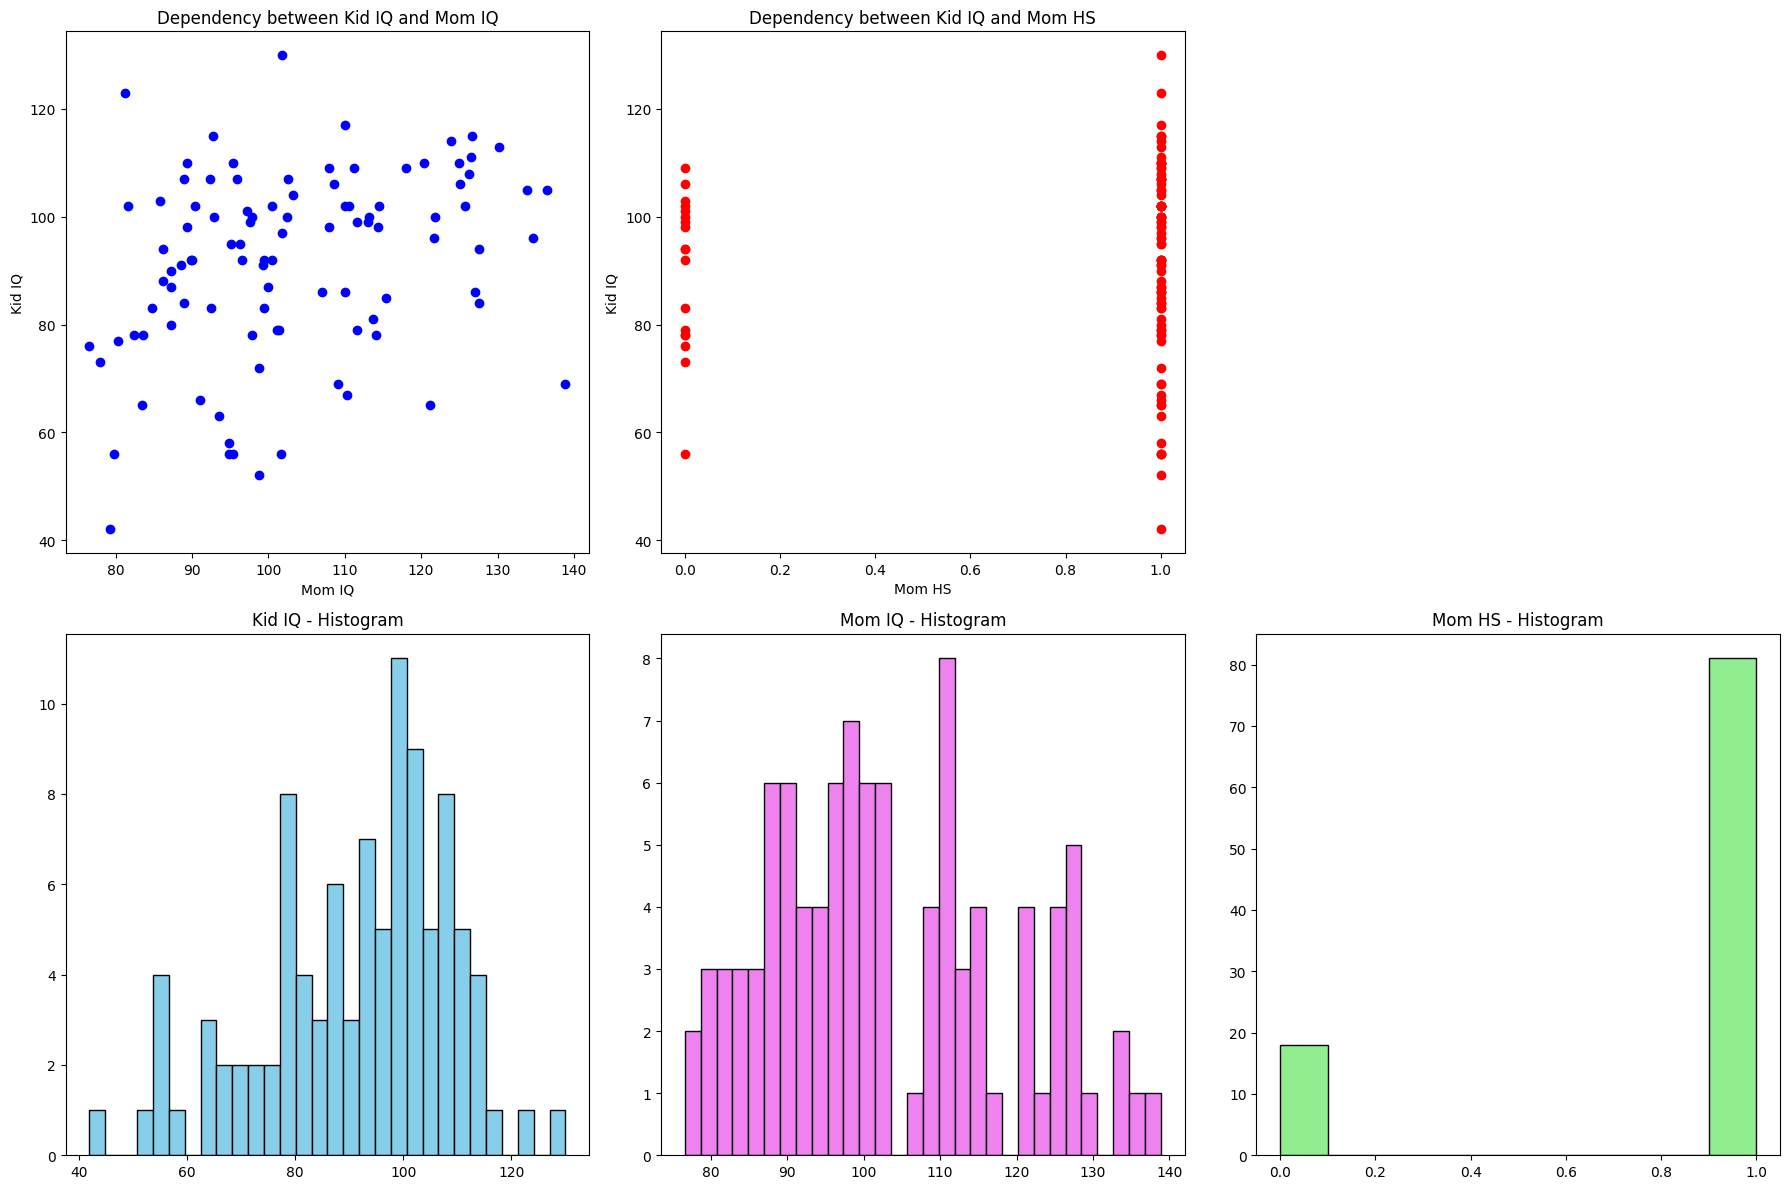

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  

axs[0, 0].scatter(df.mom_iq.values, df.kid_score.values, color='blue')
axs[0, 0].set_title("Dependency between Kid IQ and Mom IQ")
axs[0, 0].set_xlabel("Mom IQ")
axs[0, 0].set_ylabel("Kid IQ")

axs[0, 1].scatter(df.mom_hs.values, df.kid_score.values, color='red')
axs[0, 1].set_title("Dependency between Kid IQ and Mom HS")
axs[0, 1].set_xlabel("Mom HS")
axs[0, 1].set_ylabel("Kid IQ")

axs[1, 0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Kid IQ - Histogram')

axs[1, 1].hist(df.mom_iq.values, bins=30, color='violet', edgecolor='black')
axs[1, 1].set_title('Mom IQ - Histogram')

axs[1, 2].hist(df.mom_hs.values, color='lightgreen', edgecolor='black')
axs[1, 2].set_title('Mom HS - Histogram')

fig.delaxes(axs[0, 2])

plt.tight_layout()
plt.show()

# First model
Our first model is a simple linear regression model designed to predict a child's IQ score based on the mother's IQ score. This foundational model allows us to investigate the relationship between these two variables and serves as a starting point for more complex analyses. It can be described as:
$$kid.score_i \sim N(\mu_i, \sigma)$$
$$\mu_i = \beta_0 + \beta_1mom.iq_i$$


## Priors
In selecting priors for our Bayesian model, we considered both the characteristics of the given data and the distributions recommended by Mark Lai in his book "Course Handouts for Bayesian Data Analysis Class" (2019). Below, we briefly describe each parameter and its corresponding prior distribution:
1. $\beta_0$ - regression intercept: this is the expected IQ score of a child when the mother's IQ score is zero; chosen prior distribution:
$$\beta_0 \sim N(90, 15)$$
2. $\beta_1$ - slope: indicates the expected change in a child's IQ score for each one-point increase in the mother's IQ score, this parameter captures the strength and direction of the relationship between maternal and child IQ; chosen prior distribution:
$$\beta_1 \sim N(0, 1)$$
3. $\sigma$ - error standard deviation: represents the variability of child IQ scores among those with the same maternal IQ score, it accounts for the unobserved factors affecting child IQ and is assumed to be constant across different levels of maternal IQ; chosen prior distribution (recommended in Gelman, Andrew. 2006. “Prior distributions for variance parameters in hierarchical models (Comment on Article by Browne and Draper).” Bayesian Analysis 1 (3): 515–34):
$$\sigma \sim t^+(4, 0, 1)$$






### STAN

```stan
data {
  int<lower=0> N;               
  array[N] real mom_iq;        
}

generated quantities {
  real beta0 = normal_rng(90, 15);   
  real beta1 = normal_rng(0, 1);     
  real sigma = student_t_rng(4, 0, 1);

  array[N] real kid_score; 
  for (i in 1:N) {
    kid_score[i] = normal_rng(beta0 + beta1*mom_iq[i], sigma);  
  }
}

```

### Simulating data
Centering mother's IQ scores by subtracting the mean ensures that the intercept $\beta_0$ accurately reflects the expected child's IQ score when the mother's IQ is average. Subsequently, we created a simulated dataset that closely mimics the range and distribution of the actual data. The decision to simulate the data comes from the necessity to validate its functionality and to gain insights into its behavior under controlled conditions.

In [ ]:
mean_mom_iq = df['mom_iq'].mean()
df['c_mom_iq'] = df['mom_iq'] - mean_mom_iq
data_sim={'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq.min(),df.c_mom_iq.max(), num=df.shape[0])}

In [1808]:
model_1=CmdStanModel(stan_file='prior1.stan')

model_1_samp = model_1.sample(data = data_sim, chains=4, seed=2904)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


In [1809]:
yields_pred_prior = model_1_samp.stan_variable("kid_score")
yields_pred_prior_means = yields_pred_prior

In [1810]:
print(yields_pred_prior_means[1])

[ 39.5554  40.3196  41.4388  42.7488  43.4312  44.4423  45.6802  46.6452
  47.6606  48.4055  49.5457  50.7667  51.6673  52.7003  53.8285  55.1171
  56.1082  56.751   57.9158  59.0971  59.5182  61.2708  61.9659  63.1098
  64.0702  64.8725  66.5467  67.0748  68.3866  69.1676  70.1779  71.2974
  72.5398  73.4469  74.3404  75.5398  76.7142  77.4855  78.4573  79.5739
  80.6323  81.7178  82.5728  83.7287  84.3412  85.4487  86.76    87.5287
  88.8247  89.7891  90.8219  91.4781  93.0205  93.8473  94.9027  95.9146
  97.0253  98.0119  98.9619 100.19   101.39   101.977  103.28   104.128
 105.152  106.092  107.228  108.566  109.05   110.213  111.69   112.301
 113.449  114.356  115.333  116.379  117.374  118.568  119.614  120.639
 121.623  122.735  123.779  124.743  125.609  126.975  127.898  128.936
 129.929  131.116  131.713  133.09   133.879  134.879  135.955  137.022
 138.073  139.02   140.214 ]


In [1811]:
print(model_1_samp.summary())

                Mean   MCSE  StdDev   5%  50%    95%   N_Eff  N_Eff/s  R_hat
name                                                                        
lp__            0.00    NaN    0.00  0.0  0.0    0.0     NaN      NaN    NaN
beta0          45.00  0.780   47.00  0.0  0.0  110.0  3500.0   5700.0    1.0
beta1           0.02  0.011    0.71 -1.2  0.0    1.3  4000.0   6400.0    1.0
sigma           0.49  0.013    0.80  0.0  0.0    2.1  3900.0   6300.0    1.0
kid_score[1]   44.00  0.830   50.00  0.0  0.0  128.0  3623.0   5805.0    1.0
...              ...    ...     ...  ...  ...    ...     ...      ...    ...
kid_score[95]  46.00  0.870   53.00  0.0  0.0  140.0  3646.0   5844.0    1.0
kid_score[96]  46.00  0.880   53.00  0.0  0.0  141.0  3645.0   5842.0    1.0
kid_score[97]  46.00  0.880   53.00  0.0  0.0  142.0  3628.0   5814.0    1.0
kid_score[98]  46.00  0.880   53.00  0.0  0.0  142.0  3644.0   5839.0    1.0
kid_score[99]  46.00  0.890   54.00  0.0  0.0  142.0  3644.0   5839.0    1.0

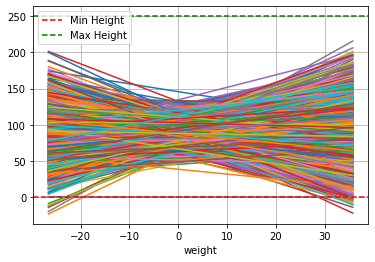

In [1812]:
alphas = model_1_samp.stan_variable('beta0')
betas = model_1_samp.stan_variable('beta1')
mean_weight = df['mom_iq'].mean()
df['c_mom_iq'] = df['mom_iq'] - mean_weight
data_sim={'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq.min(),df.c_mom_iq.max(),num=df.shape[0])}

weight = data_sim['mom_iq']
for alpha, beta in zip(alphas, betas):
    plt.plot(weight, weight * beta + alpha)
    plt.xlabel('weight')
# Check consistency with minimum and maximum heights observed in nature
min_height_observed = 0 # minimum observed height
max_height_observed = 250 # maximum observed height
plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height')
# plt.ylim([-10, 270])
plt.grid(True)
plt.legend()

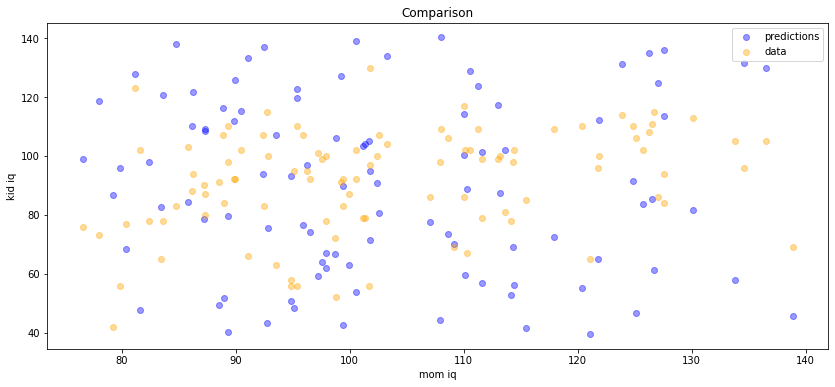

In [1813]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,yields_pred_prior_means[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [1814]:
# R = 1
model=CmdStanModel(stan_file='model1_b.stan')

model_1_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df.mom_iq.values, 'kid_score': df.kid_score.values},
                     chains=4)

INFO:cmdstanpy:compiling stan file /home/DA/kidiq2/model1_b.stan to exe file /home/DA/kidiq2/model1_b
INFO:cmdstanpy:compiled model executable: /home/DA/kidiq2/model1_b
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)




chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


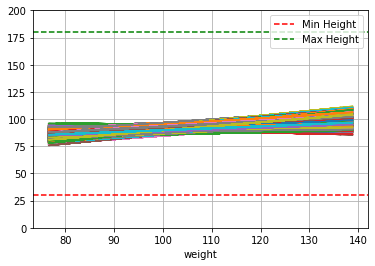

In [1815]:
alphas = model_1_fit.stan_variable('beta0')
betas = model_1_fit.stan_variable('beta1')
weight = df['mom_iq']
for alpha, beta in zip(alphas, betas):
    plt.plot(weight, weight * beta + alpha)
    plt.xlabel('weight')
# Check consistency with minimum and maximum heights observed in nature
min_height_observed = 30 # minimum observed height
max_height_observed = 180 # maximum observed height
plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height')
plt.ylim([0, 200])
plt.grid(True)
plt.legend()

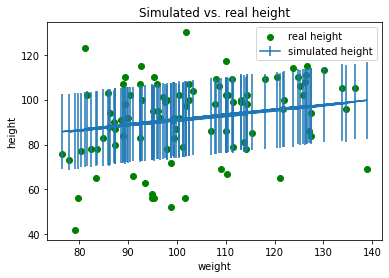

In [1816]:
heights = model_1_fit.stan_variable('kid_score_pred')
mean_heights = np.mean(heights,axis=0,)
std_heights = np.std(heights,axis=0)
real_heights = np.array(df['kid_score'])
plt.errorbar(weight, mean_heights, yerr=std_heights, label='simulated height')
plt.scatter(weight, real_heights,label='real height', color ='green')
plt.xlabel('weight')
plt.ylabel('height')
plt.title('Simulated vs. real height')
plt.legend()
plt.show()

In [1817]:
yields_pred = model_1_fit.stan_variable("kid_score_pred")
yields_pred_means = yields_pred
print(yields_pred_means[1])

[ 97.9861  79.8191  93.0862  95.421   97.9329 123.464  103.339  106.4
 100.506  108.239   91.602  108.953   69.0644  89.9186  90.6573 108.008
 113.423   86.1007  76.5996  94.7827 102.58    89.8167  99.3719  94.4803
 100.868   93.0454 105.932   88.072   78.4698  77.5462  99.5306 102.286
  82.5581 104.955   93.4641  79.847   97.4388  98.0413  69.5883  51.4677
  62.3912  81.0192  85.4356  73.3249  76.9668  88.9331  83.1209  79.4969
  92.0684  75.4588  69.0226 106.723  100.95   105.377   77.0814  99.6966
  89.8537 105.45    60.0832  79.5212  92.8344  73.8241 100.215   83.3091
  89.3239  86.5877  82.2775  71.3313  59.9599  86.9884  99.3771 103.014
  64.0223  99.5124  73.7312  74.5879  94.6501 102.987   67.0202  99.3682
  55.4428  76.0016 107.434  112.982  133.299   75.5409  96.1364  87.586
 116.203  106.666   87.9976 111.305   94.1778  75.4631  70.7419 104.908
  82.0278  90.8875  74.7302]


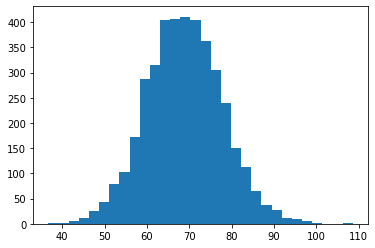

In [1818]:
beta0 = model_1_fit.stan_variable("beta0")
plt.hist(beta0, bins=30)
plt.show()

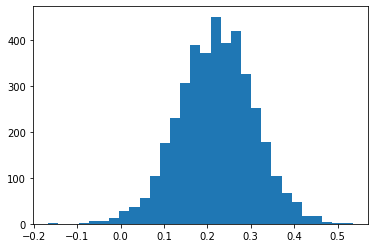

In [1819]:
beta1 = model_1_fit.stan_variable("beta1")
plt.hist(beta1, bins=30)
plt.show()

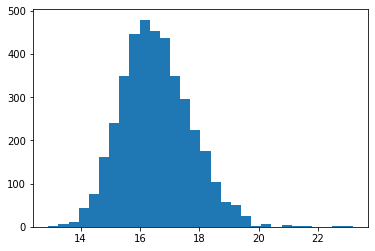

In [1820]:
sigma = model_1_fit.stan_variable("sigma")
plt.hist(sigma, bins=30)
plt.show()

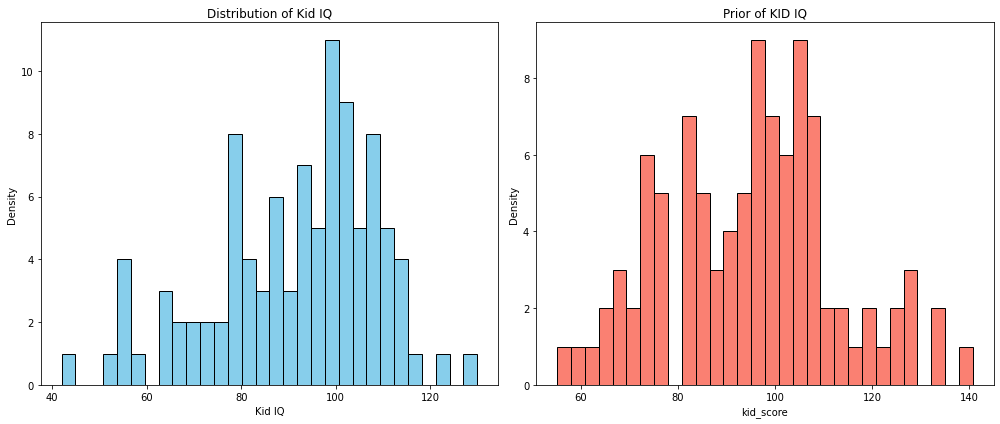

In [1821]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(yields_pred_means[0], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

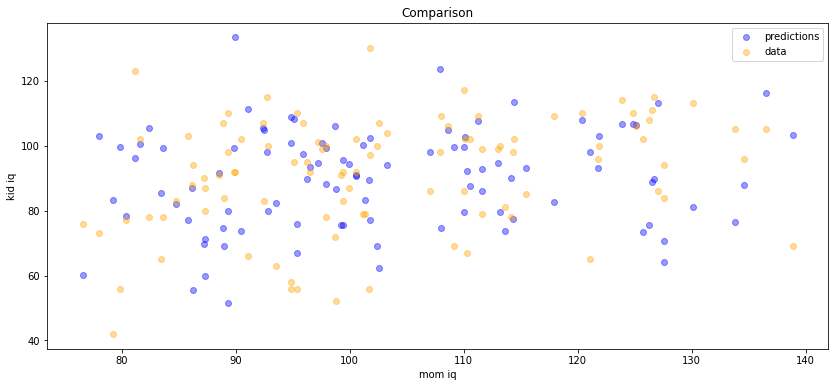

In [1822]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,yields_pred_means[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [1823]:
sum([(x - y)**2 for x,y in zip(yields_pred_means[0],df.kid_score)])

52537.79267377

Model 2

In [1824]:
mean_weight = df['mom_iq'].mean()
df['c_mom_iq'] = df['mom_iq'] - mean_weight
data_sim2 = {'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq.min(),df.c_mom_iq.max(), num=df.shape[0]), 'mom_hs': np.random.choice([0, 1], size=df.shape[0], p=[0.2, 0.8])}
# data_sim2 = {'N':df.shape[0], 'mom_iq':np.linspace(df.c_mom_iq.min(),df.c_mom_iq.max(), num=df.shape[0]), 'mom_hs': df.mom_hs}

In [1825]:
model_2=CmdStanModel(stan_file='prior2.stan')

model_2_samp = model_2.sample(data = data_sim2,
                     chains=4,
                     seed=1204)

INFO:cmdstanpy:compiling stan file /home/DA/kidiq2/prior2.stan to exe file /home/DA/kidiq2/prior2
INFO:cmdstanpy:compiled model executable: /home/DA/kidiq2/prior2
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [1826]:
yields_pred_prior = model_2_samp.stan_variable("kid_score")
# yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)
yields_pred_prior_means = yields_pred_prior

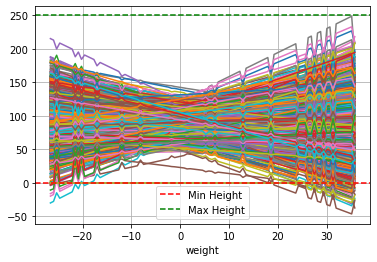

In [1827]:
betas0 = model_2_samp.stan_variable('beta0')
betas1 = model_2_samp.stan_variable('beta1')
betas2 = model_2_samp.stan_variable('beta2')
betas3 = model_2_samp.stan_variable('beta3')



weight = data_sim2['mom_iq']
hs = data_sim2['mom_hs']

for beta0, beta1, beta2, beta3 in zip(betas0, betas1, betas2, betas3):
    plt.plot(weight, beta0 + beta1*weight + beta2*hs + beta3*hs*weight)
    plt.xlabel('weight')
# Check consistency with minimum and maximum heights observed in nature
min_height_observed = 0 # minimum observed height
max_height_observed = 250 # maximum observed height
plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height')
# plt.ylim([-10, 270])
plt.grid(True)
plt.legend()

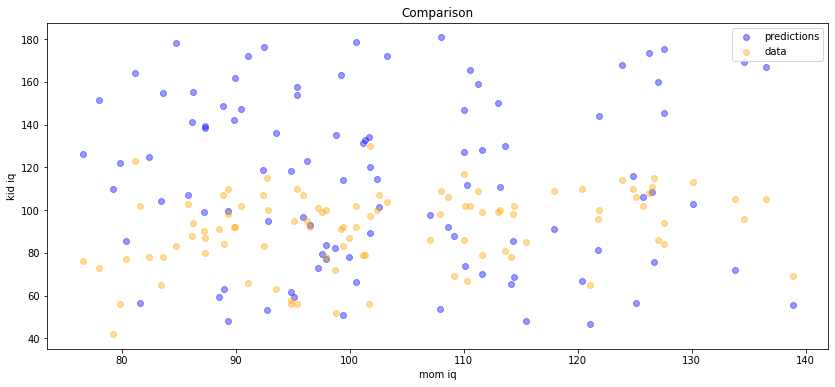

In [1828]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,yields_pred_prior_means[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [1830]:
R = 1
model=CmdStanModel(stan_file='model2.stan')

model_2_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df.mom_iq, 'kid_score': df.kid_score, 'mom_hs': df["mom_hs"].values},
                     chains=4)

INFO:cmdstanpy:compiling stan file /home/DA/kidiq2/model2.stan to exe file /home/DA/kidiq2/model2
INFO:cmdstanpy:compiled model executable: /home/DA/kidiq2/model2
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)






chain 1 |████████


INFO:cmdstanpy:CmdStan done processing.


In [1831]:
yields_pred = model_2_fit.stan_variable("kid_score_pred")
yields_pred_means = yields_pred

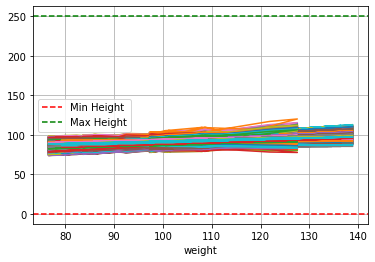

In [1832]:
betas0 = model_2_fit.stan_variable('beta0')
betas1 = model_2_fit.stan_variable('beta1')
betas2 = model_2_fit.stan_variable('beta2')
betas3 = model_2_fit.stan_variable('beta3')



weight = df['mom_iq']
hs = df['mom_hs']

for beta0, beta1, beta2, beta3 in zip(betas0, betas1, betas2, betas3):
    plt.plot(weight, beta0 + beta1*weight + beta2*hs + beta3*hs*weight)
    plt.xlabel('weight')
# Check consistency with minimum and maximum heights observed in nature
min_height_observed = 0 # minimum observed height
max_height_observed = 250 # maximum observed height
plt.axhline(y=min_height_observed, color='red', linestyle='--', label='Min Height')
plt.axhline(y=max_height_observed, color='green', linestyle='--', label='Max Height')
# plt.ylim([-10, 270])
plt.grid(True)
plt.legend()

In [1833]:
yields_pred_means

array([[108.208 ,  94.1332,  80.1257, ...,  70.8087,  92.2889, 125.366 ],
       [115.099 ,  91.4255,  78.7592, ...,  65.0429,  61.0822,  97.3078],
       [ 93.4335,  97.8512,  52.4413, ..., 115.815 ,  86.3611, 112.985 ],
       ...,
       [ 80.6258,  60.3563,  96.536 , ...,  73.4675,  79.7335,  99.4437],
       [ 80.7604, 114.044 , 104.263 , ...,  85.9848, 102.956 ,  81.432 ],
       [ 67.689 ,  86.8743,  91.6635, ..., 120.342 ,  75.4534,  89.2879]])

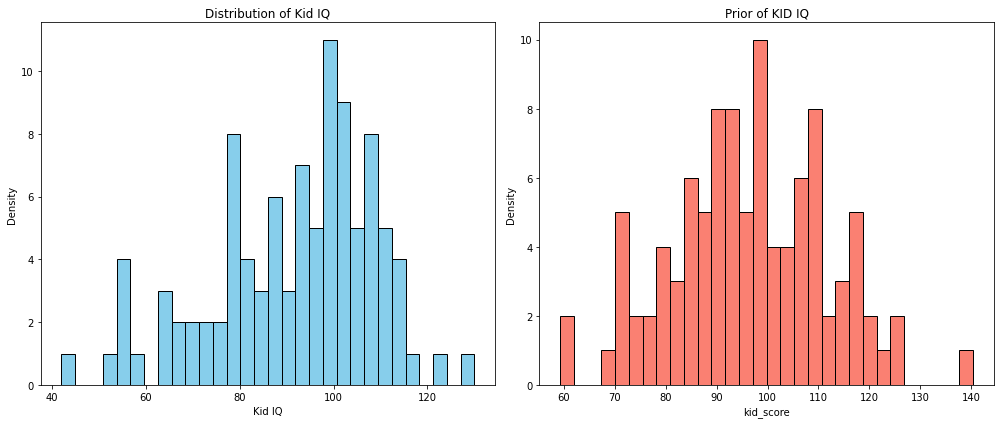

In [1834]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(yields_pred_means[0], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [1835]:
sum([(x - y)**2 for x,y in zip(yields_pred_means[0],df.kid_score)])

51362.43480015998

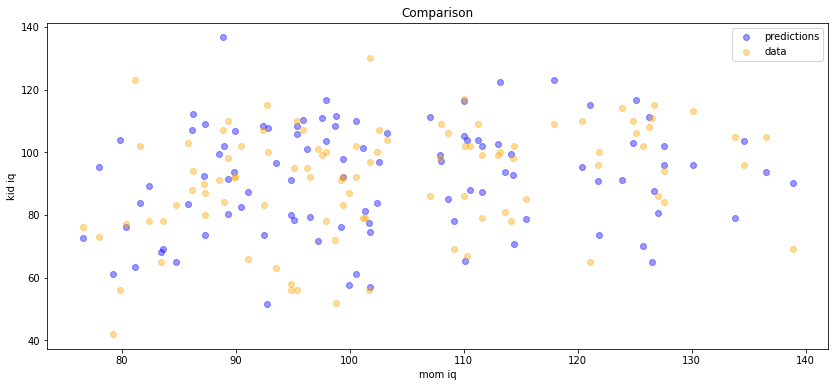

In [1836]:
plt.figure(figsize=(14,6))
plt.scatter(df.mom_iq,yields_pred_means[1], label="predictions",alpha=0.4,color='blue')
plt.scatter(df.mom_iq,df.kid_score, label="data", alpha =0.4,color='orange')
plt.title("Comparison")
plt.ylabel("kid iq")
plt.xlabel("mom iq")
plt.legend()
plt.show()

In [1837]:
sigmas = model_2_fit.stan_variable('sigma')

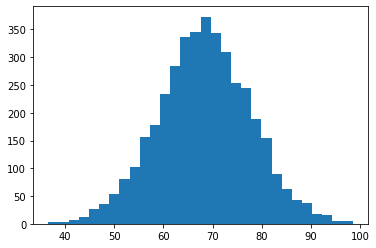

In [1838]:
plt.hist(betas0, bins=30)
plt.show()

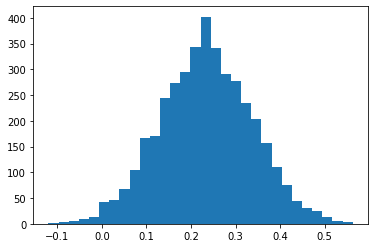

In [1839]:
plt.hist(betas1, bins=30)
plt.show()

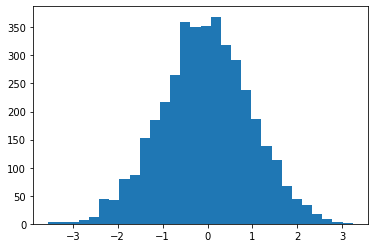

In [1840]:
plt.hist(betas2, bins=30)
plt.show()

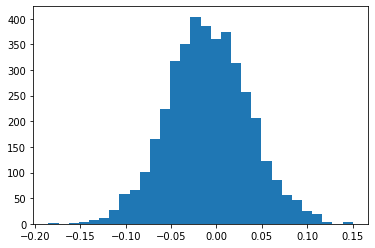

In [1841]:
plt.hist(betas3, bins=30)
plt.show()

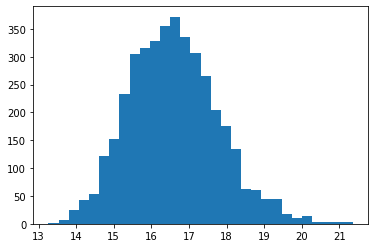

In [1842]:
plt.hist(sigmas, bins=30)
plt.show()

comparison


<AxesSubplot:xlabel='Deviance'>

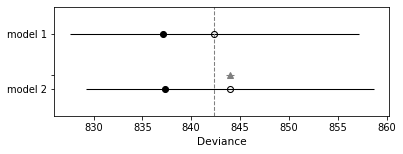

In [1843]:
import arviz as az

comp_dict = {"model 1":model_1_fit, "model 2": model_2_fit}
comp_loo = az.compare(comp_dict, ic="loo",scale="deviance")
az.plot_compare(comp_loo)

<AxesSubplot:xlabel='Deviance'>

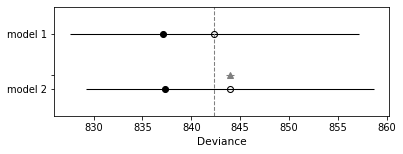

In [1844]:
comp_waic = az.compare(comp_dict, ic="waic",scale="deviance")
az.plot_compare(comp_waic)